In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install -q imagecorruptions

In [3]:
from utils import *
from utils.clr_callback import CyclicLR

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  GeForce GTX 1050 Ti, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [4]:
loader = DataLoader(split_method='balanced_epochs')

print('\nTrain data distribution')
loader.print_data_distribution('train')

print('\nValidation data distribution')
loader.print_data_distribution('val')

Class weights: {0: 0.9822766097240473, 1: 1.0699767400250493, 2: 0.9676537216828479, 3: 0.9320604738154613, 4: 1.0626565970679698}
Total train: 59801, Total val: 1630

Train data distribution
3    21.457835
2    20.668551
0    20.360864
4    18.820756
1    18.691995
Name: label, dtype: float64

Validation data distribution
4    20.0
3    20.0
2    20.0
1    20.0
0    20.0
Name: label, dtype: float64


Train data
Batch X:  (4, 300, 300, 3) -2.21809238891261 3.4227696874715763
Batch Y:  (4, 5) 0.0 1.0


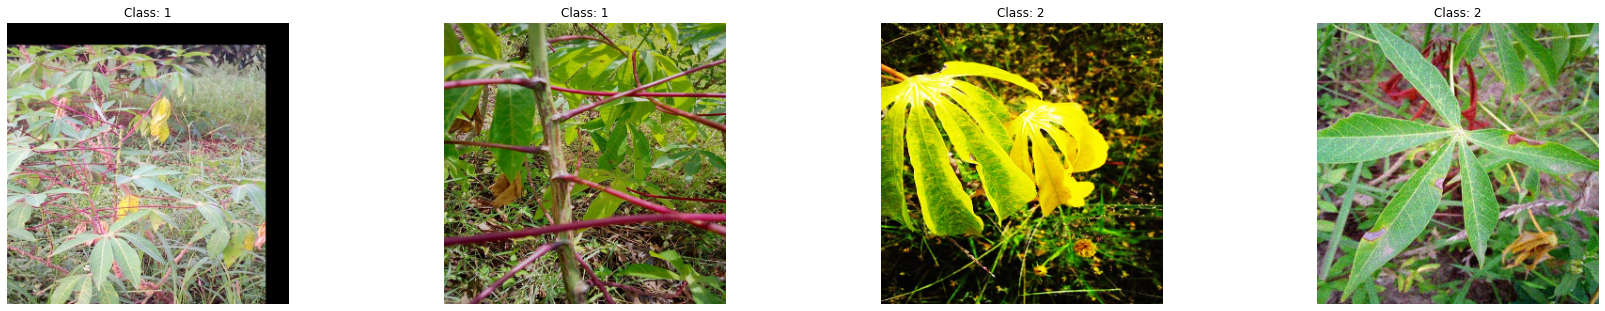

In [5]:
print('Train data')
loader.view_data(data='train', batch_size=4)

Validation data
Batch X:  (4, 300, 300, 3) -2.21809238891261 3.4227696874715763
Batch Y:  (4, 5) 0.0 1.0


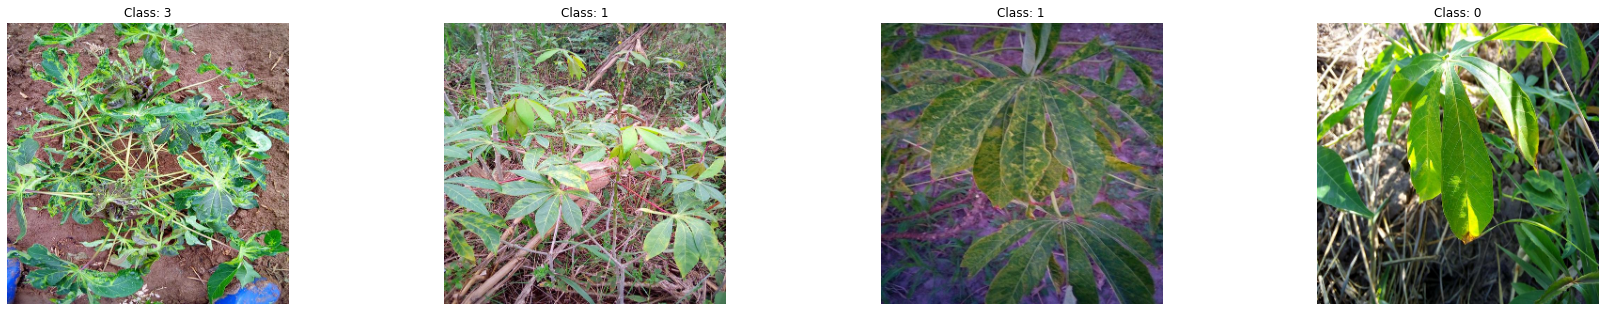

In [6]:
print('Validation data')
loader.view_data(data='val', batch_size=4)

In [7]:
model = Model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb1 (Functional)     (None, 10, 10, 1280) 6575239     input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           efficientnetb1[0][0]             
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 1280)         0           efficientnetb1[0][0]             
_______________________________________________________________________________________

In [8]:
# start training
model.fit(
    x=loader.flow('train', batch_size=BATCH_SIZE),
    steps_per_epoch=loader.data_size('train')//(2*BATCH_SIZE),
    
    class_weight=loader.class_weights,
    
    epochs=100,
    callbacks=[
               tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_auc', mode='max', 
                                                  verbose=1, save_best_only=True, save_weights_only=False),
               tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, verbose=1, 
                                                mode='max', restore_best_weights=True),
               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=2, 
                                                    verbose=1, mode='max', min_lr=1e-6, min_delta=0.01),
               tf.keras.callbacks.CSVLogger(filename='training_log.csv', separator=',', append=True),
               CyclicLR(base_lr=1e-4, max_lr=5e-4, step_size=loader.data_size('train')//(2*BATCH_SIZE),
                        mode='exp_range', gamma=0.99994)
              ],
    
    validation_data=loader.flow('val', batch_size=2),
    validation_steps=loader.data_size('val')//2,
    
    use_multiprocessing=True
)

Epoch 1/100
3737/3737 [==============================] - ETA: 0s - loss: 1.1432 - precision: 0.7257 - recall: 0.4863 - auc: 0.8745 - acc: 0.6207
Epoch 00001: val_auc improved from -inf to 0.79434, saving model to model.h5
3737/3737 [==============================] - 2226s 596ms/step - loss: 1.1432 - precision: 0.7257 - recall: 0.4863 - auc: 0.8745 - acc: 0.6207 - val_loss: 1.3864 - val_precision: 0.5484 - val_recall: 0.3681 - val_auc: 0.7943 - val_acc: 0.4871
Epoch 2/100
3737/3737 [==============================] - ETA: 0s - loss: 0.9018 - precision: 0.8269 - recall: 0.6632 - auc: 0.9392 - acc: 0.7572
Epoch 00002: val_auc improved from 0.79434 to 0.93927, saving model to model.h5
3737/3737 [==============================] - 2095s 560ms/step - loss: 0.9018 - precision: 0.8269 - recall: 0.6632 - auc: 0.9392 - acc: 0.7572 - val_loss: 0.9190 - val_precision: 0.7909 - val_recall: 0.7006 - val_auc: 0.9393 - val_acc: 0.7466
Epoch 3/100
3737/3737 [==============================] - ETA: 0s - lo

KeyboardInterrupt: 

In [ ]:
plot_loss(model.history, 'Train info', 0)

In [ ]:
plot_metrics(model.history)

In [ ]:
# evaluate model
loader.evaluate(model, 8)

In [ ]:
loader.create_submission(
    model = model,
    path_to_csv = '../input/cassava-leaf-disease-classification/sample_submission.csv',
    path_to_images = '../input/cassava-leaf-disease-classification/test_images/'
)